In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [2]:
IMAGE_SIZE = 200

In [3]:
img_dir = "./db/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() # We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

In [4]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [5]:
path = './db/annotations'
text_files = ['./db/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [6]:
resizeannotation("./db/annotations/Cars147.xml")

[168, 126, 90, 93]

In [7]:
y[0]

[167, 129, 90, 93]

In [8]:
np.array(X).shape

(433, 200, 200, 3)

In [9]:
np.array(y).shape

(433, 4)

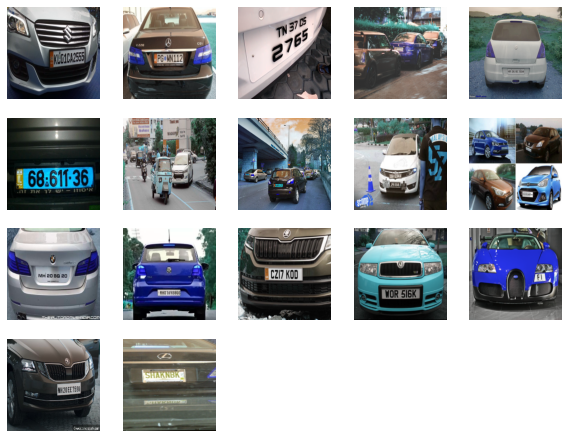

In [10]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

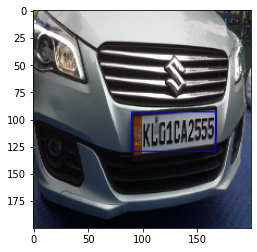

In [11]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

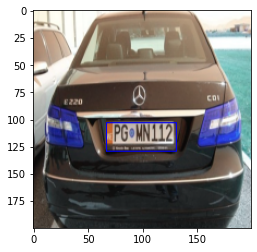

In [12]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [13]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [14]:
#Renormalisation
X = X / 255
y = y / 255

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

In [17]:
# Create the model
model = Sequential()

model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# gives me 1D ouptut (gives [1 * x])

model.add(Flatten())

#dense is used to combines features from prev layers, and is used to change dimensions (gives [input_rows, x]) 
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

# freezes the weight of the last 6 layers
model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,099,140
Trainable params: 2,384,452
Non-trainable params: 14,714,688
____________________________________

In [18]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [19]:
# k12 cross validation is used (k - 1: train, 1 :  validate)
# verbose - 0 - gives nothing
# verbose - 1 - shows animation
# verbose - 2 - shows something related to epochs?
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=1)

Epoch 1/30
13/13 [==============================] - 47s 4s/step - loss: 0.0423 - accuracy: 0.4112 - val_loss: 0.0114 - val_accuracy: 0.5000
Epoch 2/30
13/13 [==============================] - 50s 4s/step - loss: 0.0126 - accuracy: 0.6535 - val_loss: 0.0098 - val_accuracy: 0.5455
Epoch 3/30
13/13 [==============================] - 48s 4s/step - loss: 0.0062 - accuracy: 0.7545 - val_loss: 0.0070 - val_accuracy: 0.7727
Epoch 4/30
13/13 [==============================] - 45s 3s/step - loss: 0.0051 - accuracy: 0.8145 - val_loss: 0.0042 - val_accuracy: 0.9091
Epoch 5/30
13/13 [==============================] - 50s 4s/step - loss: 0.0030 - accuracy: 0.8488 - val_loss: 0.0045 - val_accuracy: 0.9091
Epoch 6/30
13/13 [==============================] - 42s 3s/step - loss: 0.0019 - accuracy: 0.8701 - val_loss: 0.0042 - val_accuracy: 0.8636
Epoch 7/30
13/13 [==============================] - 42s 3s/step - loss: 0.0010 - accuracy: 0.9104 - val_loss: 0.0038 - val_accuracy: 0.9091
Epoch 8/30
13/13 [==

In [20]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
# scores[0] gives loss
# scores[1] gives accuracy
print("Score : %.2f%%" % (scores[1]*100))

Score : 90.91%


In [39]:
def plot_scores_metrics(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='val_accuracy')
    plt.title('Scores')
    plt.legend()
    plt.show()

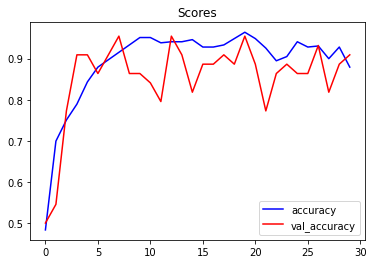

In [40]:
plot_scores_metrics(train)

In [23]:
y_cnn = model.predict(X_test)

In [24]:
y_cnn.shape

(44, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

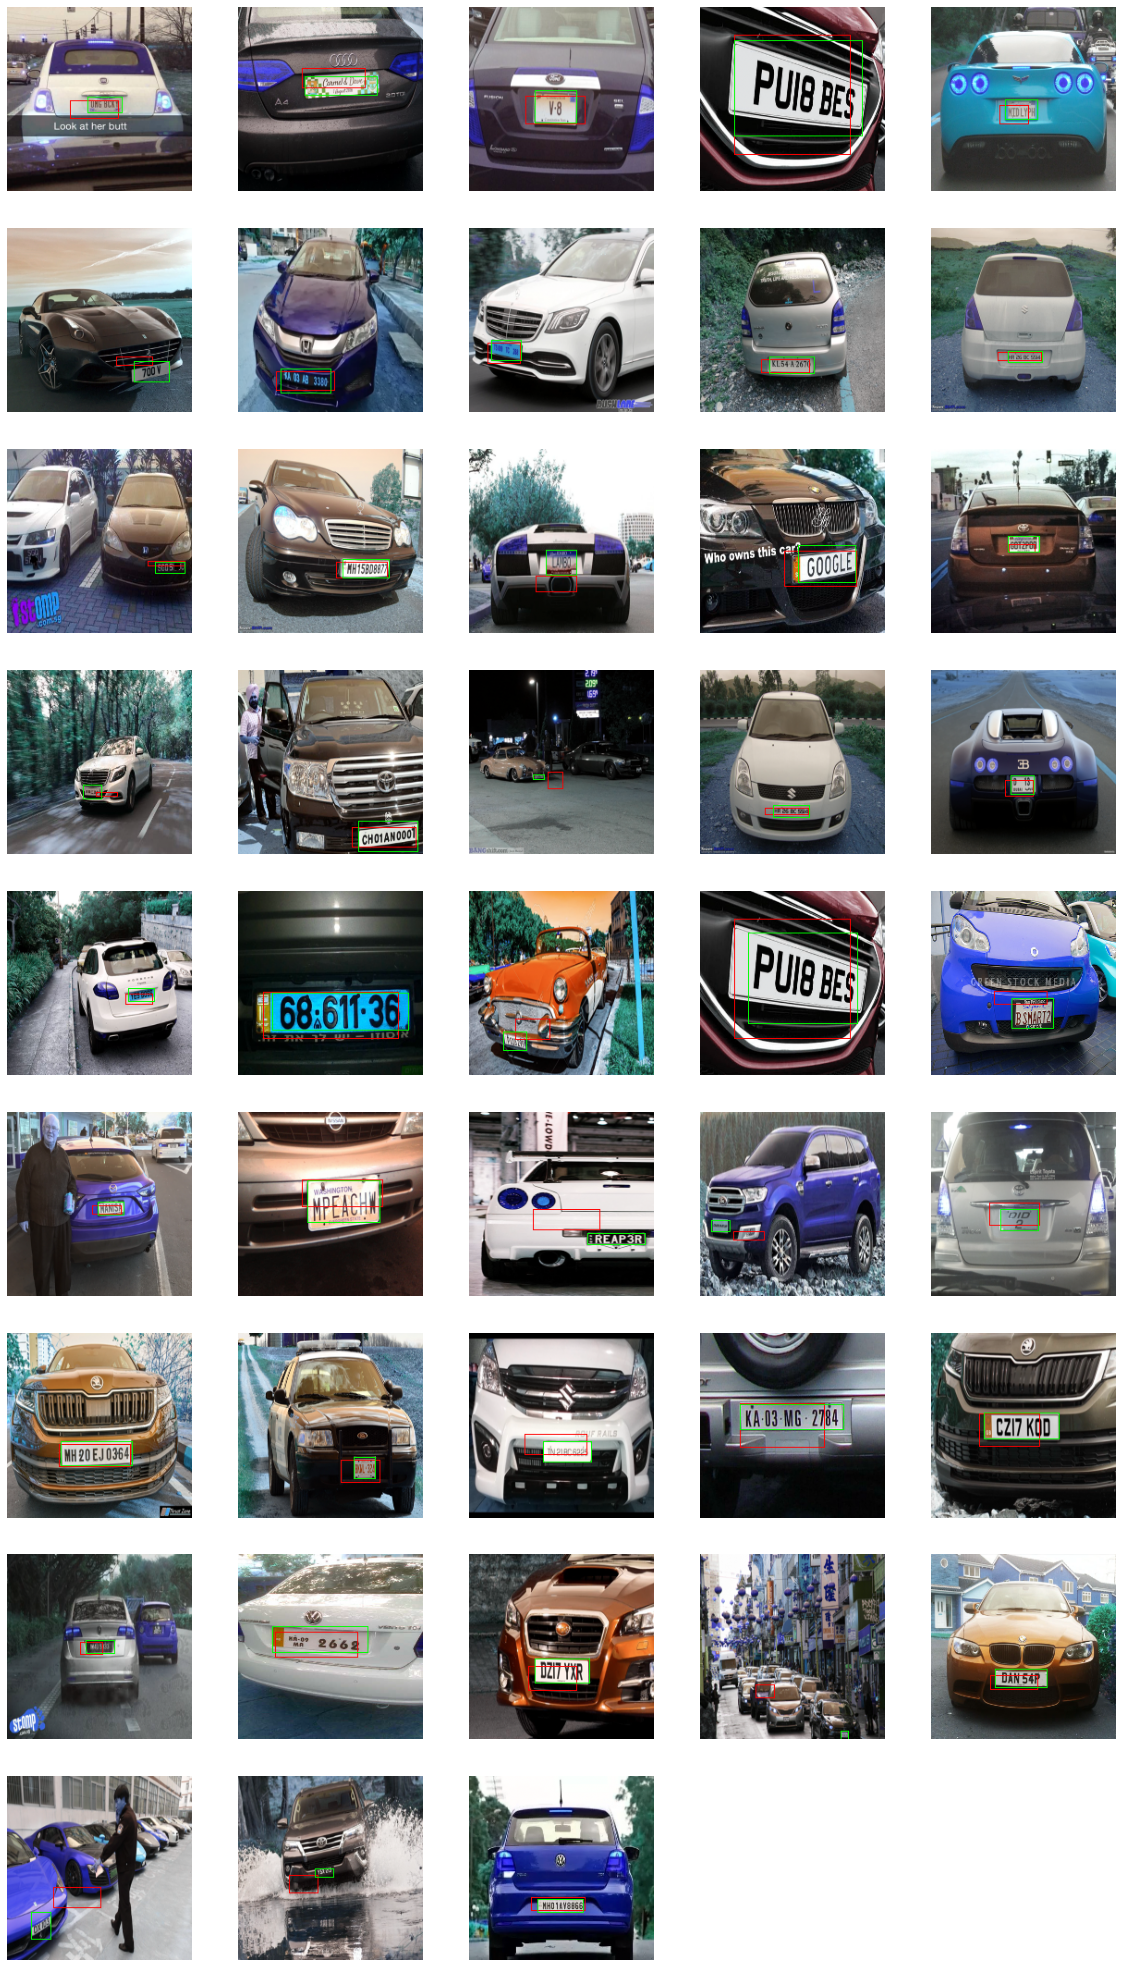

In [83]:
plt.figure(figsize=(20,40))
for i in range(0,43):
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    ny1 = y_test[i]*255
    # draw bb for prediciton 
    image1 = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(255,0 , 0))
    # draw bb for input
    image2 = cv2.rectangle(image1,(int(ny1[0]),int(ny1[1])),(int(ny1[2]),int(ny1[3])),(0, 255, 0))
    plt.imshow(image2)

In [85]:
# Intersection Over Union [ratio of I/U]
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

iou = [print(i +1, bb_intersection_over_union(y_test[i], y_cnn[i])) for i in range(0, 43)]

1 0.861447317971803
2 0.8604386168855067
3 0.8846903337260809
4 0.7621263623214568
5 0.8902383443216916
6 0.7794936616901265
7 0.9282885000580582
8 0.9580935739924944
9 0.9226294978871539
10 0.939875393567153
11 0.9347404708358261
12 0.9489739492948416
13 0.7825733305571315
14 0.8794383197884118
15 0.9323265449637166
16 0.8366620223698797
17 0.9139856681304883
18 0.8160441496112911
19 0.934826168742968
20 0.9384887543871591
21 0.9416852614445926
22 0.7966946526696812
23 0.7621276512418049
24 0.6933328213778482
25 0.7732984331965973
26 0.9459071718617246
27 0.8794566490470578
28 0.48712767237607557
29 0.7036056248945209
30 0.8896362412457129
31 0.9640369718910009
32 0.8845564548629649
33 0.8322215254302864
34 0.8058701692062554
35 0.8377863733581811
36 0.9090310822113681
37 0.8676431497272408
38 0.8427993899557145
39 0.35223055052482183
40 0.8943287615248314
41 0.5540045930272206
42 0.7489820411376586
43 0.9443948059223569


In [59]:
def plot_scores_IOU(iou):
    no_of_items = range(43);
    thresh = [0.5 for i in range(43)];
    plt.plot(no_of_items, iou, 'g', label='IOU')
    plt.plot(no_of_items, thresh, 'b', label="threshold")
    plt.title('IOU Scores')
    plt.legend()
    plt.show()

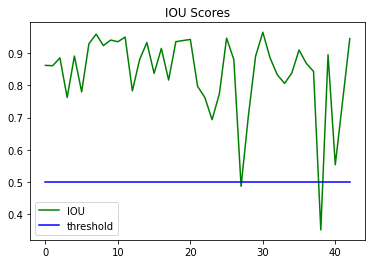

In [84]:
plot_scores_IOU(iou)